In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import mutual_info_classif

In [2]:
path = 'in-vehicle-coupon-recommendation.csv'
df = pd.read_csv(path)

In [6]:
X = df.drop('Y', axis= 1)
y = df['Y']
X

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,1,0,0,0,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,1,0,0,0,1
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,1,1,0,0,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,1,1,0,0,1
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,1,0,0,1,0
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,1,0,0,0,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,1,0,0,1,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,1,1,1,0,1


## Discussion
As we can see in the dataset many of the features of this data consist of categorical values. 
In each of one this variables we may ask if the they have numerical signficance.
For example, we may find that attributing values 1, 2, 3, ... for the income attribute may be a good criteria.
But in the coupon attribute we may find that this way of discretizing is not optimal, instead, we can use a binary criteria.
Which basically means that we can create auxiliary variables that will say if each data point way offered to use a specific coupon.



In [25]:
# Visualizing if the ordinal-scale for the income attribute is a good criteria
# for deciding the response variable.
X['income'].unique()
incomes = [ 'Less than $12500', '$12500 - $24999', '$25000 - $37499',
            '$37500 - $49999', '$50000 - $62499', '$62500 - $74999',
            '$75000 - $87499', '$87500 - $99999', '$100000 or More']
enc = OrdinalEncoder(categories=[incomes])
X['income'] = enc.fit_transform(X[['income']])

In [29]:
zero_counts = { income: 0 for income in X['income'] }
one_counts = { income: 0 for income in X['income'] }

for income, _y in zip( X['income'], y ):
    if _y == 0:
        zero_counts[income] += 1
    else:
        one_counts[income] += 1

12684

In [32]:
# Seems like the cout above is correct, since this works
test = 0
for key, value in zero_counts.items():
    test += value
for key, value in one_counts.items():
    test += value
print(test)

12684


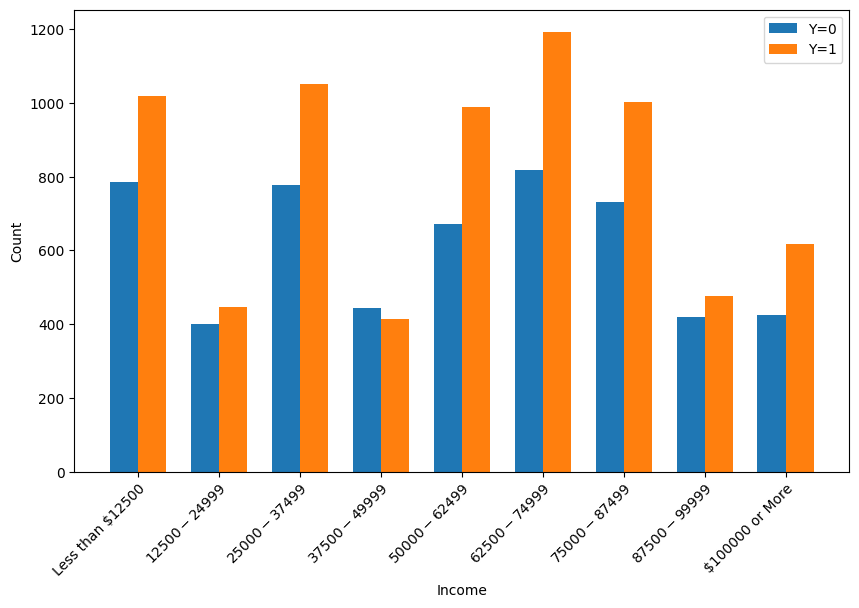

In [51]:
fig_income, axes_income = plt.subplots( figsize=(10, 6) )

bar_width = 0.35
index = np.arange(len(incomes))

bars_y0 = axes_income.bar(index, zero_counts.values(), bar_width, label='Y=0')
bars_y1 = axes_income.bar(index + bar_width, one_counts.values(), bar_width, label='Y=1')

axes_income.set_xlabel('Income')
axes_income.set_ylabel('Count')
axes_income.set_xticks(index+bar_width/2)
axes_income.set_xticklabels(incomes, rotation=45, ha='right', rotation_mode='anchor')
axes_income.legend()

plt.show()

Text(0, 0.5, 'Ratios')

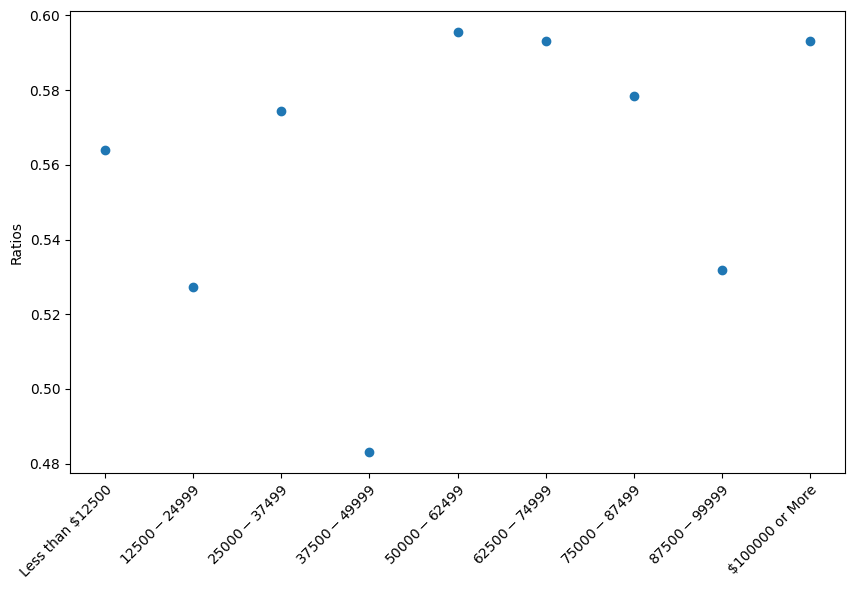

In [73]:
income_ratios = []
list_ones = list(one_counts.values())
list_zeros = list(zero_counts.values())
for i in range(len(list_ones)):
    ratio = list_ones[i] / ( list_ones[i] + list_zeros[i] )
    income_ratios.append( ratio )
fig_ratios, axes_ratios = plt.subplots( figsize=(10, 6) )
xticks = np.arange(len(income_ratios))
axes_ratios.scatter( xticks, income_ratios )

axes_ratios.set_xticks(xticks)
axes_ratios.set_xticklabels(incomes, rotation=45, ha='right', rotation_mode='anchor')
axes_ratios.set_ylabel("Ratios")
    

## Conclusion about income being a ordinal encoder.
As we can see in figure above there is no apparently linear relation in increasing the salary
and incresing the probability of accepting the coupon. So it is not a good idea to use salary as a ordinal encoder.
But for using as a parameter in K-nearest-neighbors, the income attribute may be a good attribute, so we will use it as
a One Hot Encoder.

In [94]:
# redefining the matrices to its original form
path = 'in-vehicle-coupon-recommendation.csv'
df = pd.read_csv(path)
X = df.drop('Y', axis= 1)
y = df['Y']

In [95]:
# Creating a one_hot_encoder for income in the final Matrix.
one_hot_encoder_income = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
one_hot_encoder_incomeTransform = one_hot_encoder_income.fit_transform(X[['income']])
X_final = pd.concat( [X, one_hot_encoder_incomeTransform], axis=1 ).drop( columns= ['income'] )

# Deciding for some variables that are kind of trivial to define its categorical behaviour
---
## Destination
As we can clearly see there is no hierarquy between the attribute **destination**. So we can already assume that we will use them as a One Hot Encoder in the final Matrix.

Notice that this attribute may be essential to define the acceptence of the coupon, since the activity the costumer is going to do is deterministic to accepting the coupon.


In [87]:
# As we can see, there is no worries to handle with unknown data...
np.unique( X['destination'] )

array(['Home', 'No Urgent Place', 'Work'], dtype=object)

In [96]:
one_hot_encoder_destination = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
one_hot_encoder_destinationTransform = one_hot_encoder_destination.fit_transform(X[['destination']])
X_final = pd.concat( [X_final, one_hot_encoder_destinationTransform], axis=1 ).drop( columns=['destination'])

## Passanger
The **passanger** attribute can be seen as the **destination** attribute. Since it can be viewed as some essential data for deciding the coupon acceptence.

In [93]:
# As we can see, there are no unknows.
np.unique( X['passanger'] )

array(['Alone', 'Friend(s)', 'Kid(s)', 'Partner'], dtype=object)

In [97]:
one_hot_encoder_passanger = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
one_hot_encoder_passangerTransform = one_hot_encoder_passanger.fit_transform(X[['passanger']])
X_final = pd.concat( [X_final, one_hot_encoder_passangerTransform], axis=1 ).drop( columns=['passanger'] )

## Weather
